# 4 - TVL Regression
In this section, we inspect the TVL graphs manually, then specify the number of turning points for `pwlf` to perform piecewise linear fit. This mathematically breaks down the TVL trend into multiple stages.

In [6]:
# Standard Library
import math
import os

# Third Party Library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Local Folder Library
from pyammanalysis import pwlf_helper
from pyammanalysis.util import read_yaml

In [9]:
# config
config = read_yaml("../config.yaml")
SUBPLOTS_PER_ROW = config["SUBPLOTS_PER_ROW"]

# data folder paths
DATA_PATH = config["DATA_PATH"]

pools_df = pd.read_csv(os.path.join(DATA_PATH, "pools_df.csv"))
pool_names = pools_df["name"]

pool_day_df = pd.read_csv(
    os.path.join(DATA_PATH, "pool_day_df.csv"), parse_dates=["date"]
)

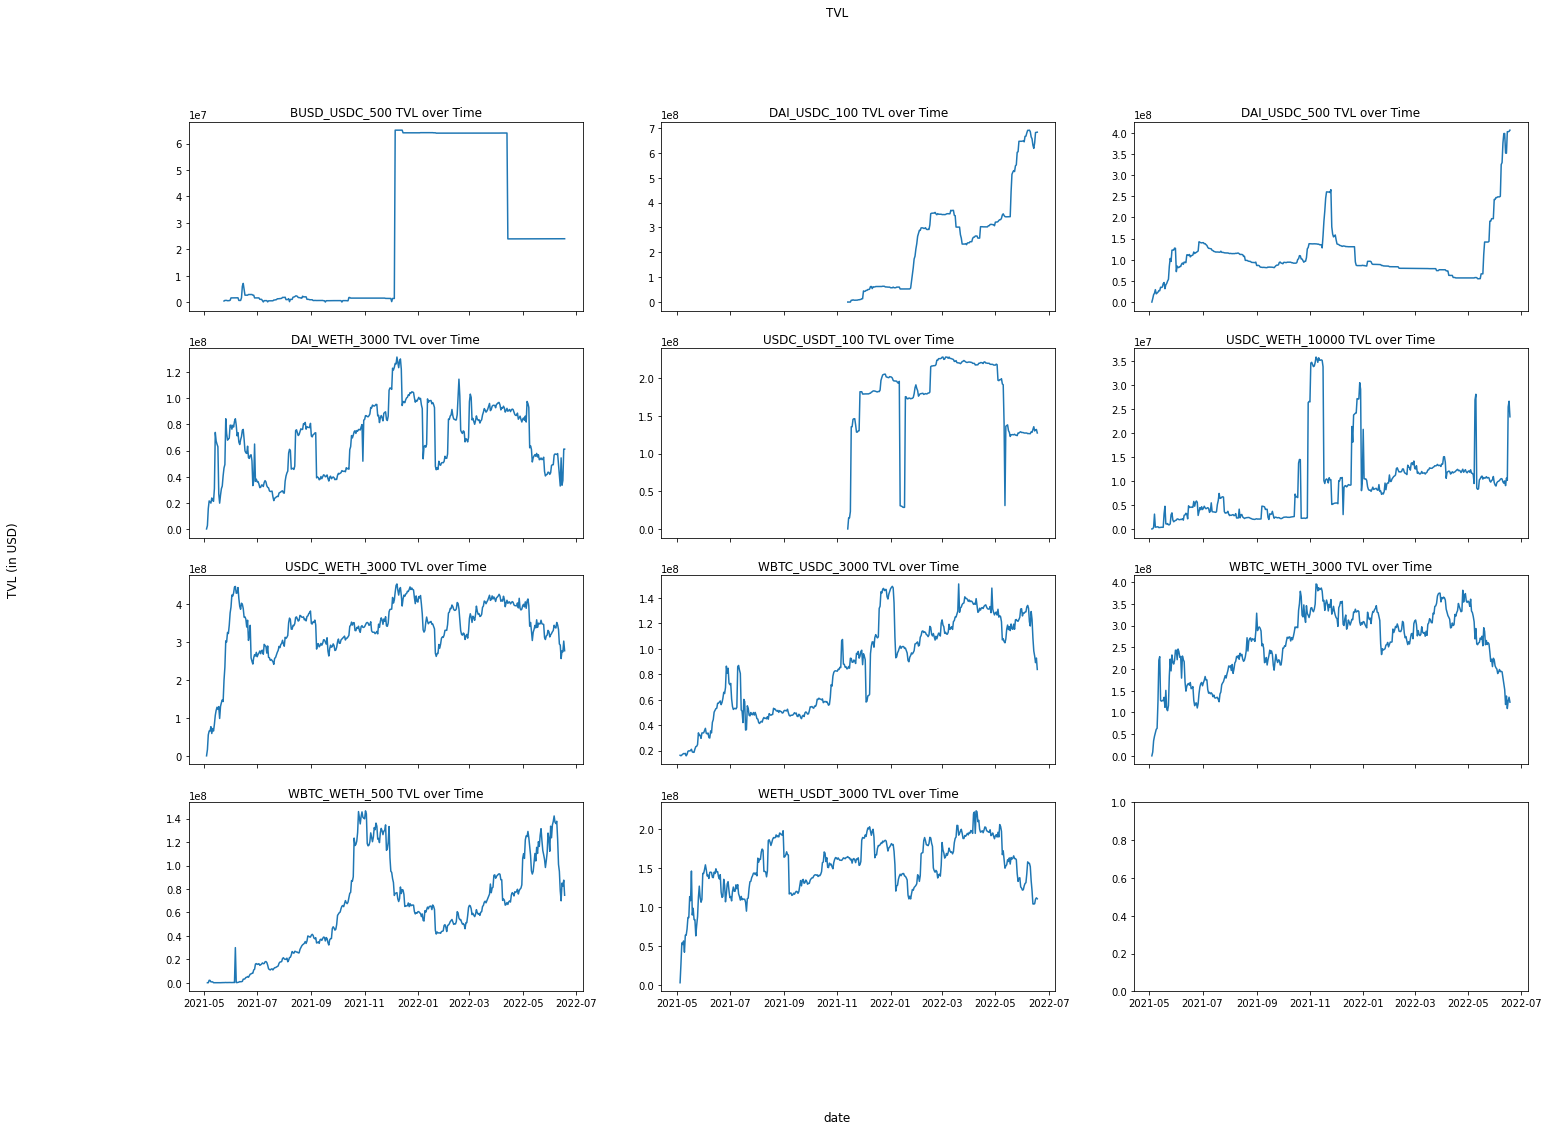

In [8]:
fig = plt.figure(figsize=(24, 16))
axes = fig.subplots(4, SUBPLOTS_PER_ROW, sharex=True)
for i, pool_name in enumerate(pool_names):
    date_tvl_df = pool_day_df[["date", pool_name + "_tvlUSD", "timestamp"]].dropna()

    ax = axes[math.floor(i / SUBPLOTS_PER_ROW), i % SUBPLOTS_PER_ROW]
    ax.title.set_text(pool_name + " TVL over Time")

    ax.plot(date_tvl_df["date"], date_tvl_df[pool_name + "_tvlUSD"])

fig.suptitle("TVL")
fig.supxlabel("date")
fig.supylabel("TVL (in USD)")
plt.show()

In [18]:
recompute_regression = False

if recompute_regression:
    yHats = np.empty(len(pool_names), dtype=np.ndarray)
    # default to 5 turning points to avoid heavy computation, customizable
    # 11 pools, 5 segments each => 20 s
    n_segments = np.full(len(pool_names), 5)

    for i, pool_name in enumerate(pool_names):
        date_tvl_df = pool_day_df[["date", pool_name + "_tvlUSD", "timestamp"]].dropna()
        yHats[i] = pwlf_helper.regression(
            date_tvl_df["timestamp"], date_tvl_df[pool_name + "_tvlUSD"], n_segments[i]
        ).yHat

    # write np array as binary
    with open(f"{DATA_PATH}/tvl_yHats.npy", "wb") as f:
        np.save(f, yHats, allow_pickle=True)

else:
    # read np array from binary
    with open(f"{DATA_PATH}/tvl_yHats.npy", "rb") as f:
        yHats = np.load(f, allow_pickle=True)

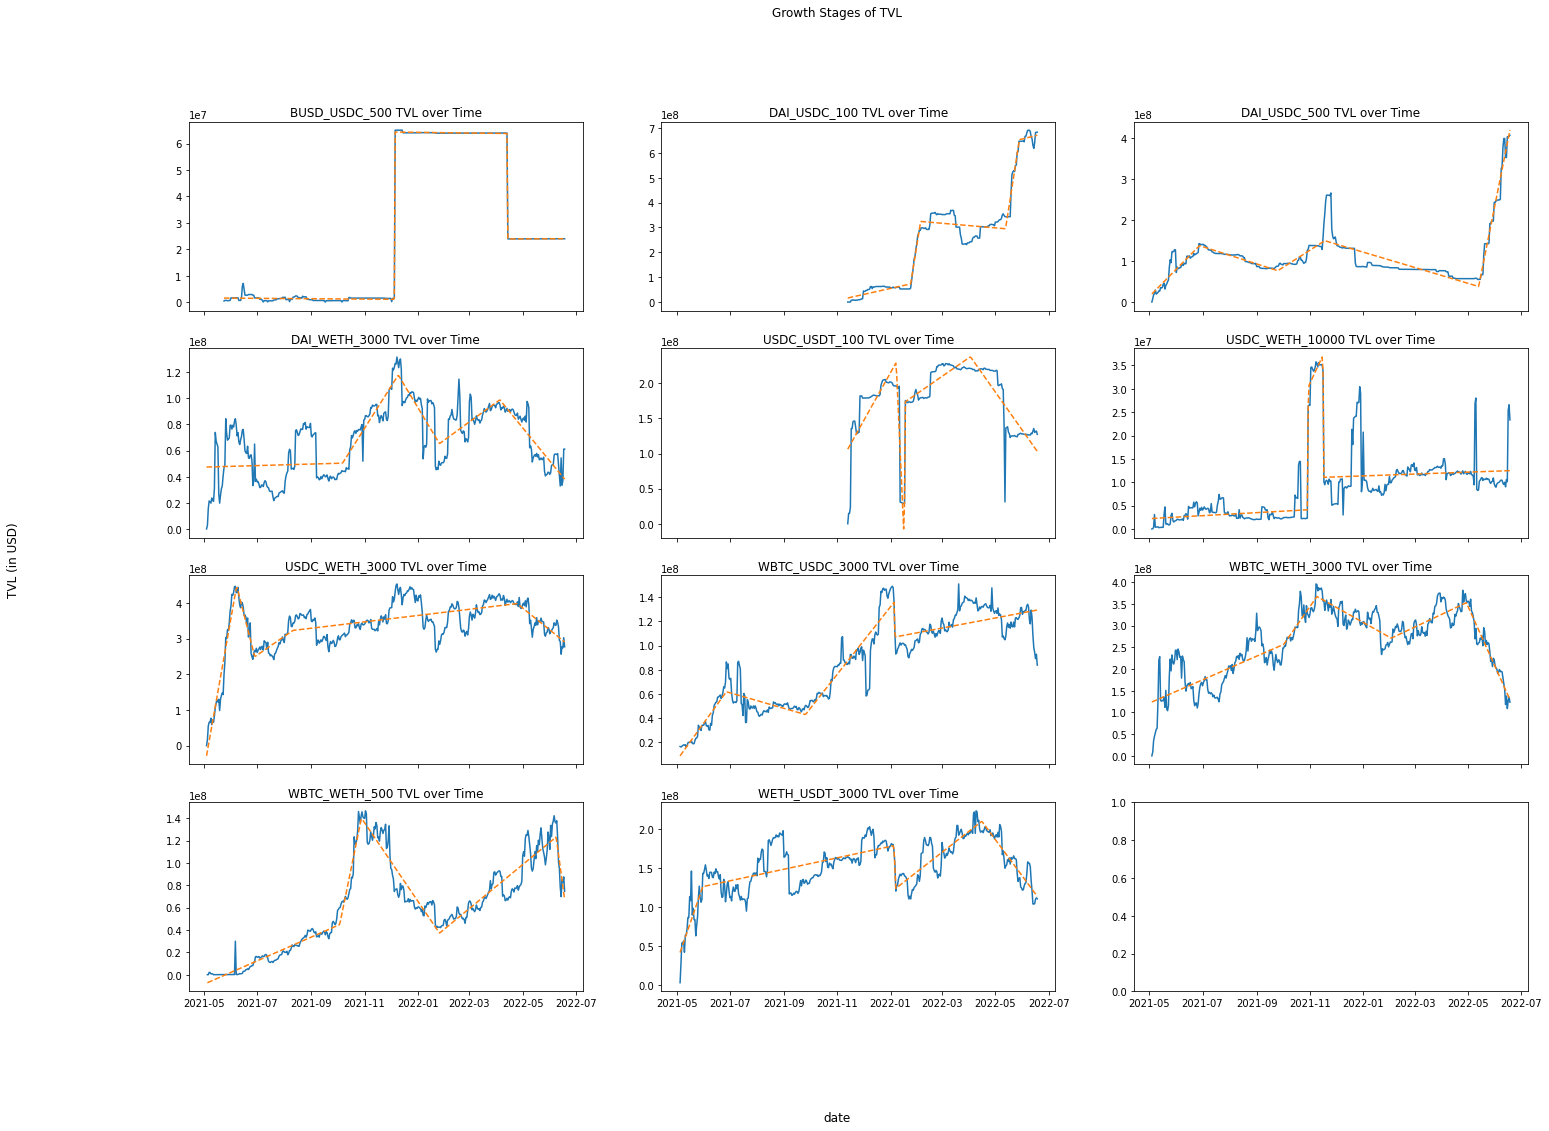

In [19]:
fig = plt.figure(figsize=(24, 16))
axes = fig.subplots(4, SUBPLOTS_PER_ROW, sharex=True)
for i, pool_name in enumerate(pool_names):
    date_tvl_df = pool_day_df[["date", pool_name + "_tvlUSD", "timestamp"]].dropna()

    ax = axes[math.floor(i / SUBPLOTS_PER_ROW), i % SUBPLOTS_PER_ROW]
    ax.title.set_text(pool_name + " TVL over Time")

    ax.plot(date_tvl_df["date"], date_tvl_df[pool_name + "_tvlUSD"])
    ax.plot(date_tvl_df["date"], yHats[i], "--")

    # ax.legend(["TVL", "PWLF fitted trend line"])

    # # x-axis ticks are spaced out biweekly (for now)
    # ax.xticks(pd.date_range(date_tvl_df["date"].iloc[0], date_tvl_df["date"].iloc[-1], freq="14D"))

    # # annotate turning points
    # for tp in reg_result.tp[1:-1]:
    #     tp_date = dt.date.fromtimestamp(tp)
    #     tp_str = tp_date.strftime("%Y-%m-%d")
    #     pred = reg_result.predict(tp)
    #     ax.annotate(tp_str, xy=(tp_date, pred), xytext=(tp_date, pred+0.5e8),
    #         arrowprops=dict(arrowstyle="->", color='red')
    # )

fig.suptitle("Growth Stages of TVL")
fig.supxlabel("date")
fig.supylabel("TVL (in USD)")
plt.show()